In [1]:
import numpy as np
from numpy.random import multivariate_normal
from multiview.cluster.mv_k_means import MultiviewKMeans
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_covtype
import matplotlib.pyplot as plt

In [2]:
# Create artificial dataset where conditional independence assumption 
# between views given true labels is enforced. We will construct this dataset
# by taking the forest covertypes dataset. From 6 different classes, we will 
# create 3 artificial class with 2 views each.

def get_data(num_samples=200):
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    cov = fetch_covtype()
    all_data = np.array(cov.data)
    all_targets = np.array(cov.target)
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = [1, 2, 3]
    view2_classes = [4, 5, 6]
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(num_samples)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for class_num in view1_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], num_samples)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample 200 items from each of the selected classes in view2
    for class_num in view2_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], num_samples)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(num_samples * len(view1_classes))
    view1_data = np.vstack(view1_data)
    view2_data = np.vstack(view2_data)
    view1_data = view1_data[shuffled_inds]
    view2_data = view2_data[shuffled_inds]
    magnitudes1 = np.linalg.norm(view1_data, axis=0)
    magnitudes2 = np.linalg.norm(view2_data, axis=0)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((1, -1))
    magnitudes2 = magnitudes2.reshape((1, -1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]
    return view1_data, view2_data, labels


In [4]:
v1_data, v2_data, labels = get_data()

In [17]:
# Functions to compute the cluster entropies with respect to the true label
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        if(part_size == 0):
            part_size = 1
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

def getEntropies(v1_data, v2_data, labels):
    entropies = list()
    for num in range(1, 7):
        kmeans = MultiviewKMeans(k = num)
        clusters = kmeans.fit_predict([v1_data, v2_data], num)
        ent = compute_entropy(clusters, labels, num, 3)
        entropies.append(ent)
    return entropies

def getSingleEntropies(v1_data, v2_data, labels):
    
    v_data = np.concatenate([v1_data, v2_data], axis = 1)
    entropies = list()
    
    for num in range(1, 7):
        kmeans = KMeans(n_clusters = num)
        clusters = kmeans.fit_predict(v_data)
        ent = compute_entropy(clusters, labels, num, 3)
        entropies.append(ent)
        
    return entropies

In [18]:
#Do multiview kmeans and get entropy values for each k over 100 trials
num_trials = 100
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)
mult_entropies = np.mean(mult_entropies, axis=0)


#Do single view kmeans and get entropy values for each k over 100 trials
num_trials = 100
sing_entropies = list()
for ind in range(num_trials):
    entropies = getSingleEntropies(v1_data, v2_data, labels)
    sing_entropies.append(entropies)
sing_entropies = np.array(sing_entropies)
sing_entropies = np.mean(sing_entropies, axis=0)

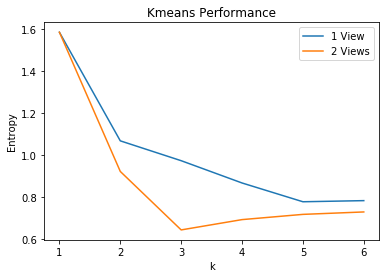

In [19]:
# Plotting the results. If the conditional independence assertion holds
# between views, then the multiview clustering should have better performance
# (lower cluster entropy) than single view kmeans clustering across the 
# range of k values, and especially at k = 3, which is the true number of 
# underlying classes. 

import matplotlib.pyplot as plt
x_values = list(range(1, 7))
plt.plot(x_values, sing_entropies, x_values, mult_entropies)
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['1 View', '2 Views'])
plt.title('Kmeans Performance')
plt.show()